In [1]:
# Image Super Resolution using Autoencoders
import os
from matplotlib import pyplot
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import pathlib
import tensorflow as tf

In [2]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)
images = list(data_dir.glob('*/*.jpg'))

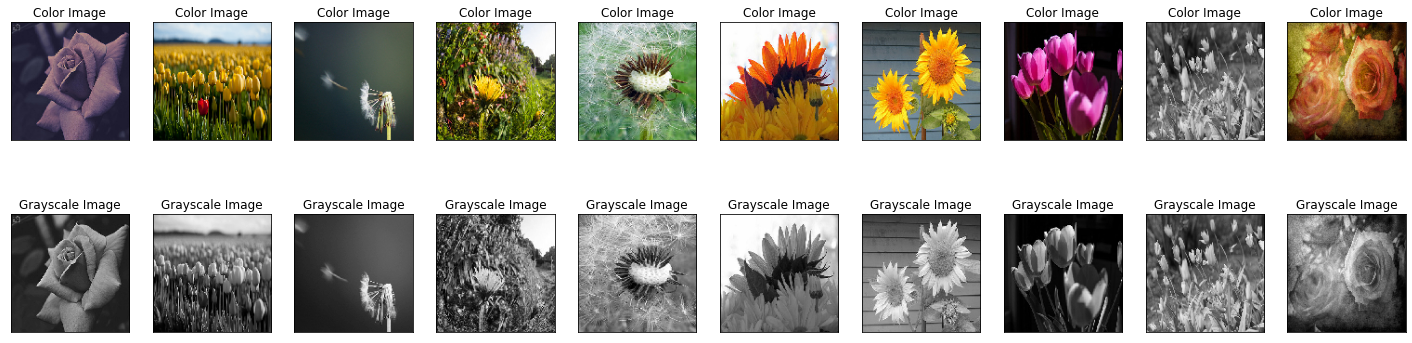

In [3]:
n = 10
plt.figure(figsize= (25,10))
for i in range(n):
  ax = plt.subplot(3, n, i+1)
  index = np.random.randint(0, len(images))
  img = image.load_img(images[index], target_size=(128,128,3))
  plt.imshow(img)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.title('Color Image')
  ax = plt.subplot(3, n, i+1+n)
  img_gray = image.load_img(images[index], target_size=(128,128,3), color_mode='grayscale')
  plt.imshow(img_gray, cmap='gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.title('Grayscale Image')
plt.show()

In [4]:
# Building a AE Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, add, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Building the Encoder
input_img = Input(shape=(128, 128, 3))
l1 = Conv2D(16, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(input_img)
l2 = MaxPooling2D(padding='same')(l1)
l2 = Dropout(0.2)(l2)

l3 = Conv2D(32, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l2)
# Building the Decoder
l4 = UpSampling2D()(l3)
l4 = Dropout(0.2)(l4)
l5 = Conv2D(16, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l4)
l6 = add([l1, l5])
# chan = 1, for Gray
decoded = Conv2D(1, (3, 3), padding='same', activation=None,
                 activity_regularizer=regularizers.l1(10e-10))(l6)

# Create our network
autoencoder = Model(input_img, decoded)

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 64, 64, 16)   0           ['conv2d[0][0]']                 
                                                                                              

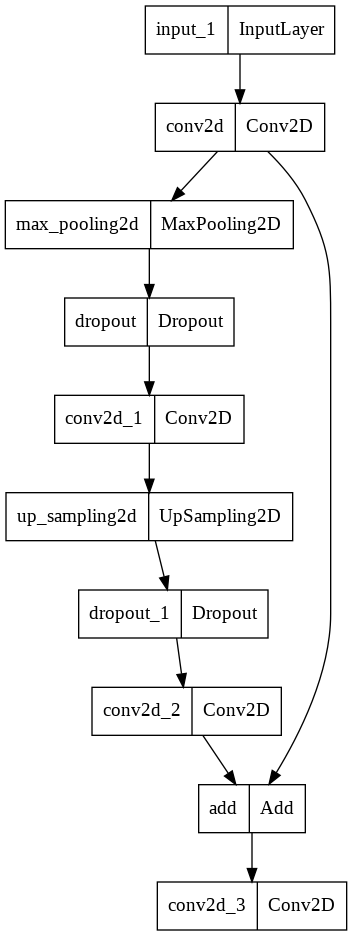

In [5]:
tf.keras.utils.plot_model(
    autoencoder,
    to_file="AE_model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)

In [6]:
# Defining callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3,
                              min_lr=0.00001, mode='auto', cooldown=1)
early_stop = EarlyStopping(monitor='val_loss', patience=7)
model_checkpoint =  ModelCheckpoint('RGB2GRAY_AutoEncoder.h5', save_best_only = True, monitor="val_loss")
callbacks = [reduce_lr, early_stop, model_checkpoint]

In [7]:
# Training the AE model
x_train_gray = []
x_train_color = []
progress = tqdm(total= 2560, position=0)
for x in range(0, 2560):
  try:
      index = np.random.randint(0, len(images))
      img = image.load_img(images[index], target_size=(128,128,3))
      img = image.img_to_array(img)/255.
      x_train_color.append(img)
      img_gray = image.load_img(images[index], target_size=(128,128,3), color_mode='grayscale')
      img_gray = image.img_to_array(img_gray)/255.
      x_train_gray.append(img_gray)
      del images[index]
      progress.update(1)
  except:
      del images[index]
      progress.update(1)
      print("Error loading image")

print("Length of training set: ", len(x_train_gray))
history_ae = autoencoder.fit(np.array(x_train_color), np.array(x_train_gray),
              epochs=50,
              batch_size=32,
              shuffle=True,
              validation_split=0.15,
              callbacks=callbacks)

100%|█████████▉| 2551/2560 [00:29<00:00, 159.42it/s]

Length of training set:  2560
Epoch 1/50
68/68 [==============================] - ETA: 0s - loss: 0.0120

100%|██████████| 2560/2560 [00:40<00:00, 159.42it/s]

68/68 [==============================] - 10s 106ms/step - loss: 0.0120 - val_loss: 0.0044 - lr: 0.0010
Epoch 2/50
 1/68 [..............................] - ETA: 5s - loss: 0.0046

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


68/68 [==============================] - 7s 97ms/step - loss: 0.0027 - val_loss: 0.0013 - lr: 0.0010
Epoch 3/50
68/68 [==============================] - 7s 97ms/step - loss: 9.9518e-04 - val_loss: 6.1027e-04 - lr: 0.0010
Epoch 4/50
68/68 [==============================] - 7s 96ms/step - loss: 5.3504e-04 - val_loss: 3.8946e-04 - lr: 0.0010
Epoch 5/50
68/68 [==============================] - 7s 96ms/step - loss: 3.6780e-04 - val_loss: 2.9383e-04 - lr: 0.0010
Epoch 6/50
68/68 [==============================] - 7s 96ms/step - loss: 2.8900e-04 - val_loss: 2.3916e-04 - lr: 0.0010
Epoch 7/50
68/68 [==============================] - 7s 100ms/step - loss: 2.4207e-04 - val_loss: 2.0634e-04 - lr: 0.0010
Epoch 8/50
68/68 [==============================] - 7s 97ms/step - loss: 2.0915e-04 - val_loss: 1.8157e-04 - lr: 0.0010
Epoch 9/50
68/68 [==============================] - 7s 101ms/step - loss: 1.8612e-04 - val_loss: 1.6471e-04 - lr: 0.0010
Epoch 10/50
68/68 [==============================] - 7s 1

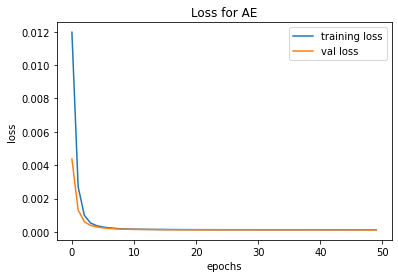

In [8]:
# Plotting graphs for loss
plt.plot(history_ae.history['loss'], label='training loss')
plt.plot(history_ae.history['val_loss'], label='val loss')
plt.title('Loss for AE')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

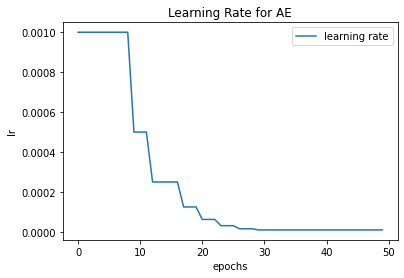

In [9]:
# Plotting graphs for lr
plt.plot(history_ae.history['lr'], label='learning rate')
plt.title('Learning Rate for AE')
plt.xlabel('epochs')
plt.ylabel('lr')
plt.legend()
plt.show()

In [10]:
# Building a CNN Model
input_img = Input(shape=(128, 128, 3))
l1 = Conv2D(32, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(input_img)
l1 = Dropout(0.2)(l1)
l2 = Conv2D(1, (3, 3), padding='same', activation=None,
                 activity_regularizer=regularizers.l1(10e-10))(l1)

# Create our network
cnn = Model(input_img, l2)

cnn.compile(optimizer='adam', loss='mse')
cnn.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 dropout_2 (Dropout)         (None, 128, 128, 32)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 1)       289       
                                                                 
Total params: 1,185
Trainable params: 1,185
Non-trainable params: 0
_________________________________________________________________


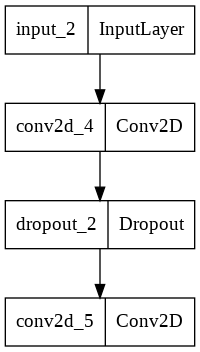

In [11]:
tf.keras.utils.plot_model(
    cnn,
    to_file="CNN_model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)

In [12]:
# Training the CNN model
model_checkpoint =  ModelCheckpoint('RGB2GRAY_CNN.h5', save_best_only = True, monitor="val_loss")
callbacks = [reduce_lr, early_stop, model_checkpoint]
print("Length of training set: ", len(x_train_gray))
history_ae = cnn.fit(np.array(x_train_color), np.array(x_train_gray),
              epochs=50,
              batch_size=32,
              shuffle=True,
              validation_split=0.15,
              callbacks=callbacks)

Length of training set:  2560
Epoch 1/50
68/68 [==============================] - 5s 52ms/step - loss: 0.0198 - val_loss: 0.0038 - lr: 0.0010
Epoch 2/50
68/68 [==============================] - 3s 50ms/step - loss: 0.0072 - val_loss: 0.0022 - lr: 0.0010
Epoch 3/50
68/68 [==============================] - 3s 50ms/step - loss: 0.0051 - val_loss: 0.0015 - lr: 0.0010
Epoch 4/50
68/68 [==============================] - 3s 49ms/step - loss: 0.0040 - val_loss: 0.0011 - lr: 0.0010
Epoch 5/50
68/68 [==============================] - 3s 50ms/step - loss: 0.0034 - val_loss: 9.6064e-04 - lr: 0.0010
Epoch 6/50
68/68 [==============================] - 3s 51ms/step - loss: 0.0029 - val_loss: 7.6040e-04 - lr: 0.0010
Epoch 7/50
68/68 [==============================] - 3s 49ms/step - loss: 0.0026 - val_loss: 7.0826e-04 - lr: 0.0010
Epoch 8/50
68/68 [==============================] - 3s 51ms/step - loss: 0.0024 - val_loss: 5.7937e-04 - lr: 0.0010
Epoch 9/50
68/68 [==============================] - 3s 49m

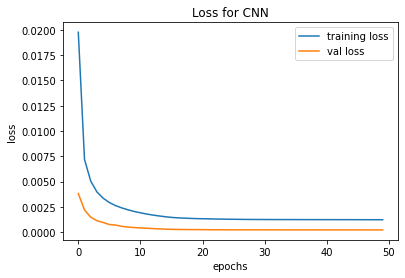

In [13]:
# Plotting graphs for loss
plt.plot(history_ae.history['loss'], label='training loss')
plt.plot(history_ae.history['val_loss'], label='val loss')
plt.title('Loss for CNN')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

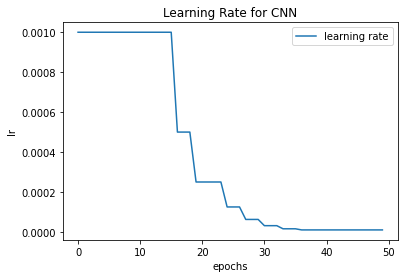

In [14]:
# Plotting graphs for lr
plt.plot(history_ae.history['lr'], label='learning rate')
plt.title('Learning Rate for CNN')
plt.xlabel('epochs')
plt.ylabel('lr')
plt.legend()
plt.show()

In [15]:
x_test_color = []
x_test_gray = []
progress = tqdm(total= len(images), position=0)
for x in range(0, len(images)):
  try:
    index = np.random.randint(0, len(images))
    img = image.load_img(images[index], target_size=(128,128,3))
    img = image.img_to_array(img)/255.
    x_test_color.append(img)
    img_gray = image.load_img(images[index], target_size=(128,128,3), color_mode='grayscale')
    img_gray = image.img_to_array(img_gray)/255.
    x_test_gray.append(img_gray)
    del images[index]
    progress.update(1)
  except:
    del images[index]
    progress.update(1)
    print("Error loading image")

100%|██████████| 1110/1110 [00:07<00:00, 152.46it/s]

In [16]:
#Evalutaing the model on test_data set
results_AE = autoencoder.evaluate(np.array(x_test_color), np.array(x_test_gray))
results_CNN = cnn.evaluate(np.array(x_test_color), np.array(x_test_gray))
print('AE Loss on Test dataset: ', results_AE)
print('CNN Loss on Test dataset: ', results_CNN)

35/35 [==============================] - 1s 18ms/step - loss: 2.2845e-04
AE Loss on Test dataset:  0.00012085494381608441
CNN Loss on Test dataset:  0.00022845080820843577


In [17]:
predictions_AE = autoencoder.predict(np.array(x_test_color))
predictions_CNN = cnn.predict(np.array(x_test_color))

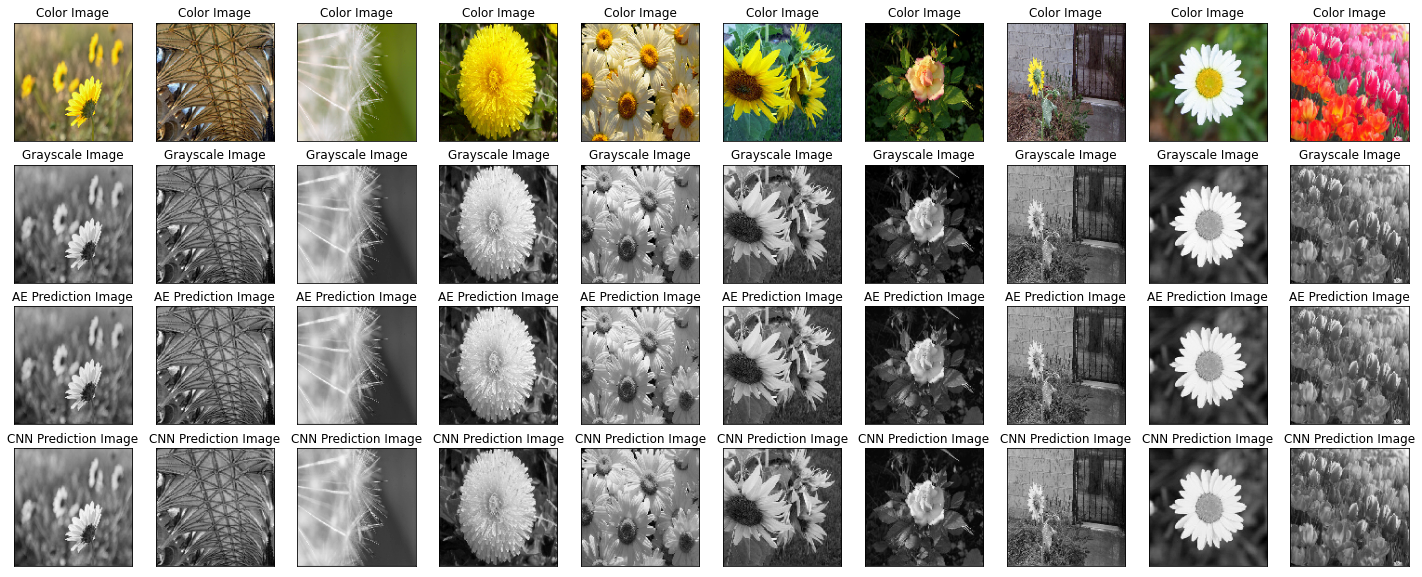

In [18]:
n = 10
plt.figure(figsize= (25,10))
for i in range(n):
  ax = plt.subplot(4, n, i+1)
  index = np.random.randint(0, len(x_test_color))
  plt.imshow(x_test_color[index])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.title('Color Image')
  ax = plt.subplot(4, n, i+1+n)
  act_img = image.array_to_img(x_test_gray[index])
  plt.imshow(act_img, cmap='gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.title('Grayscale Image')
  ax = plt.subplot(4, n, i+11+n)
  pred_ae = image.array_to_img(predictions_AE[index])
  plt.imshow(pred_ae, cmap='gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.title('AE Prediction Image')
  ax = plt.subplot(4, n, i+21+n)
  pred_cnn = image.array_to_img(predictions_CNN[index])
  plt.imshow(pred_cnn, cmap='gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.title('CNN Prediction Image')
plt.show()

In [19]:
# Represeting Model as JSON String
autoencoder_json = autoencoder.to_json()
with open('RGB2GRAY_AE_model.json', 'w') as json_file:
  json_file.write(autoencoder_json)

cnn_json = cnn.to_json()
with open('RGB2GRAY_CNN_model.json', 'w') as json_file:
  json_file.write(cnn_json)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
